# Développement d’un module de classification d’images IHC par IA

### By Maëlle Broustal, Rafik Mankour & Ian Pellet

## Import

In [10]:
import numpy as np
import pandas as pd
import skimage
import skimage.draw
import matplotlib.pyplot as plt
from xml.dom import minidom as minidom
import PIL 

In [3]:
from tensorflow import keras as k

In [65]:
k.__version__

'2.4.0'

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Openslide

In [67]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [68]:
import openslide

## Annotation

L'annotion est faite sous ce format : (les ... représentent un skip)
```
<Annotations><Annotation LineColor="65535" Name="Layer 1" Visible="True"><Regions><Region Type="Polygon" HasEndcaps="0" 
NegativeROA="0"><Vertices><V X="2667" Y="16944" /><V X="2667" Y="16967" />
<V X="2667" Y="17058" /><V X="2576" Y="17422" /><V X="2440" Y="18104" /><V X="2394" Y="18445" /><V X="2394" Y="18627" /><V X="2394" Y="18900" />
<V X="2394" Y="19286" /><V X="2394" Y="19696" /><V X="2394" Y="20082" /><V X="2303" Y="20423" /><V X="2281" Y="20651" /><V X="2190" Y="20946" />
<V X="2099" Y="21242" /><V X="2112" Y="21410" /><V X="2112" Y="21545" /><V X="2090" Y="21613" /><V X="2090" Y="21725" /><V X="2090" Y="21793" />
<V X="2090" Y="21838" /> ... <V X="2090" Y="21928" /></Vertices></Region> </Regions></Annotation></Annotations>

```

### etree.ElementTree

#### Extraction de vertex

Méthode 1:
trouver la fonction qui le fait déjà à notre place

Méthode 2:
* pour récupérer les points:
  * récupérer l'annotation comme un string
  * extraire name, NegativeROA
  * extraire chaque coordonnée: liste de vertices? X et Y
* pour utiliser la fonction polygon:
  * créer les vecteurs d'un point au suivant (nécessité de notion d'ordre -> array & df ok)
  * c'est tout

In [ ]:
import xml.etree.ElementTree as ET

tree = ET.parse('annot.annotations')
root = tree.getroot()

# one specific item attribute
print('Item #2 attribute:')
print(root[0][0][0][0][0].attrib)
#root[annotations][annotation][régions][région][sommet]

# all item attributes
print('\nAll attributes:')
for elem in root:
    for subelem in elem:
        print(subelem.attrib)

# one specific item's data
print('\nItem #2 data:')
print(root[0].text)

# all items data
print('\nAll item data:')
for elem in root:
    for subelem in elem:
        print(subelem.text)

In [ ]:
len(root), len(root[0]), len(root[0][0]), len(root[0][0][0]), len(root[0][0][0][0]), len(root[0][0][0][0][0])

In [ ]:
# liste of vertices:

#liste de polygones avec tous leurs vertices
#liste de listes (les polygones) d'objets (les vertices)
# [ [régionA-vertice1, régionA-vertice2, régionA-verticeplein], [régionB-vertice 1, régionB-vertice2, régionB-verticebcp...]]

print('\nAll vertices:')

vertices_list = [[]for i in range(len(root[0][0]))]
for annotation in root: #normalement y a qu'une
  for regions in annotation: #normalement y en a qu'une
    for n, region in enumerate(regions):
      print("new region")
      print(n)
      for vertices in region:
        for vertice in vertices:
          vertices_list[n].append(vertice.attrib)

vertices_list

### dom.minidom

#### Extraction vertex d'une annotation

In [12]:
#pour Rafik
annot = minidom.parse("/content/drive/MyDrive/data/annot.annotations") # open XML file

In [ ]:
#pour Mallou
annot = minidom.parse("/content/drive/MyDrive/Projet 4BIM/data/annot.annotations") # open XML file

In [14]:
regions = annot.getElementsByTagName("Region") # list of regions in the annotation file
print(len(regions))

26


In [15]:
V = [] # list of vertices in each region
V_coord = [] # list of coord of each vertex in each region
for r in regions :
  if r.getAttribute("NegativeROA")=='0': 
    vertices = r.getElementsByTagName("V")
    V.append(vertices)
    
    v_coord = []
    for v in vertices :
        coord = {"X": v.getAttribute('X'), "Y": v.getAttribute('Y')}
        v_coord.append(coord)
    V_coord.append(v_coord)

In [ ]:
########### ça plante oskour c'est trop gros

matrices = []
for el in V_coord:
  x_coord = []
  y_coord = []
  for vert in el :
    x_coord.append(int(vert['X']))
    y_coord.append(int(vert['Y']))
  x_coord = np.array(x_coord)
  y_coord = np.array(y_coord)
  matrices.append(skimage.draw.polygon(x_coord, np.array(y_coord), shape=None))

#### Passage de la matrice au vertex_list

**Maëlle** 

Ressortir une liste de liste de dictionnaire qui sera exploitée ensuite (fonction de Ian si dessous)

entrée: liste de matrice(liste de liste) correspondant aux pixels de l'image, chaque matrice contient une zone remarquable (polygon)

--> regarder si polygon_perimeter s'applique dans ce cas 
https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.polygon_perimeter


#### Création nouvelle annotation (vertex -> xml)

On veut d'abord convertir la matrice de coordonnées données par l'outil de classification en liste de vertices V_coord nécessaire à la composition du fichier xml.

In [ ]:
################ MARCHE PAS ENCORE

coord = np.array([[1, 1, 0, 1, 1], [1, 0, 0, 0, 0], [1, 1, 1, 1, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0]])

V_coord = [] # Pour convertir une matrice en liste de coordonnées
for sub1, sub2 in coord: 
      
    # zip() used to form pairing 
    for ele in zip(sub1, sub2): 
        V_coord.append(ele) 

ValueError: ignored

In [16]:
new_annot = minidom.Document() # create a new file

annotations = new_annot.createElement("Annotations") # create element Annotations

annotation = new_annot.createElement("Annotation") # create element Annotation
# set all the attributes 
annotation.setAttribute('LineColor',"65535") 
annotation.setAttribute('Name', "Layer 1")
annotation.setAttribute('Visible', "True")

annotations.appendChild(annotation) # add Annotation to Annotations

<DOM Element: Annotation at 0x7f1cea674eb0>

In [18]:
for R in V_coord:
    new_region = new_annot.createElement("Region") # create a new region
    for V in R:
        new_vertice = new_annot.createElement("V") # create a new vertice
        # set vertice's coord
        new_vertice.setAttribute('X', V['X'])
        new_vertice.setAttribute('Y', V['Y'])
        
        new_region.appendChild(new_vertice) # add vertice to region
        
    annotation.appendChild(new_region) # add region to annotation

In [19]:
new_annot.appendChild(annotations) # add Annotations to our document

<DOM Element: Annotations at 0x7f1cea674b90>

In [ ]:
myfile = open("annot_new.annotations", "w") # open a new file
myfile.write(new_annot.toprettyxml()) # write the content of our document in XML in the file
myfile.close()

## Chargement image

In [ ]:
img_test = openslide.OpenSlide('./data/CRC1.ndpi') # open whole-slide image

In [ ]:
#Mallou
img_test = openslide.OpenSlide('/content/drive/MyDrive/Projet 4BIM/data/CRC1.ndpi')

In [ ]:
img_test.level_dimensions # dimensions for each levels of the slide

((64512, 53760),
 (32256, 26880),
 (16128, 13440),
 (8064, 6720),
 (4032, 3360),
 (2016, 1680),
 (1008, 840),
 (504, 420),
 (252, 210),
 (126, 105))

In [ ]:
img_test.level_downsamples # downsample rates of each level

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)

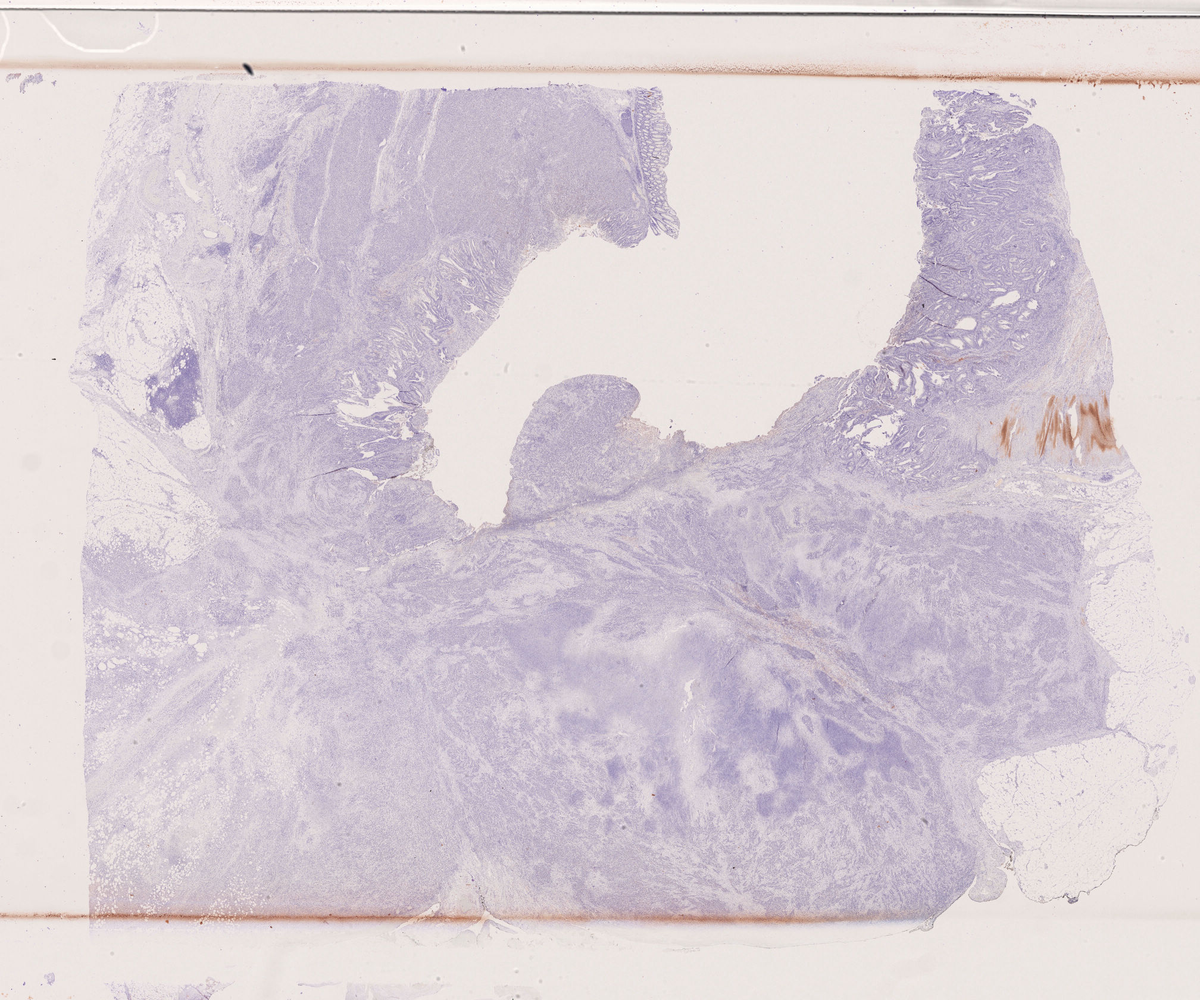

In [ ]:
img_test.get_thumbnail((1200, 1200)) # RGB image of the slide of size (1200,1200)

In [ ]:
# for each level, print level and size and open a region of the slide
max_size = (1800, 1000)
for lvl in range(img_test.level_count):
    lvl_size = img_test.level_dimensions[lvl]
    print(lvl, lvl_size)
    disp_size = max_size if lvl_size > max_size else lvl_size

    img_test.read_region((0,0), lvl, disp_size).show()

0 (64512, 53760)
1 (32256, 26880)
2 (16128, 13440)
3 (8064, 6720)
4 (4032, 3360)
5 (2016, 1680)
6 (1008, 840)
7 (504, 420)
8 (252, 210)
9 (126, 105)


In [ ]:
# we can extract a region of a level of our slide 
PIL_img = img_test.read_region((8000,4000), 5, (1200, 1200))
type(PIL_img)

PIL.Image.Image

In [ ]:
np_img = np.array(PIL_img) # convert PIL Image to a Numpy array
np_img.shape # RGBA

(1200, 1200, 4)

In [ ]:
lvl = 5 # levels 0 to 2 are to big 
full_img = img_test.read_region((0,0), lvl, img_test.level_dimensions[lvl])
full_np = np.array(full_img)
full_np.shape

(1680, 2016, 4)

In [ ]:
img_test.close() # close image